# TP1 - Redes Neuronales

## Ej 1 - Diagnóstico de cáncer de mamas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.preprocessing as skl
import pickle

Definición de variables globales de configuración de la red.

In [2]:
P = 0 
S = []
L = len(S)

lr = 0.01
B = 1 # mini-lotes incremental 1

Modelo completo
1. Leer dataset y normalizar datos.
2. Setear variables globales de configuracion de la red.
3. Testear modelo:
    * Cargar modelo entrenado (matriz W).
    * Realizar activación para todas las instancias.
    * Comparar con resultados esperados.
4. Entrenar modelo:
    * Inicializar modelo (matriz W).
    * Realizar entrenamiento.
    * Guardar modelo entrenado.
    * Graficar error en funcion de epochs.

In [989]:
def model(model_file, dataset_file, mode):
    X,target = load_dataset(dataset_file) 
    
    # TODO separar en data de train, test, validation.
    
    #mpl.scatter( np.arange(len(X)), X[:,7], alpha=0.3)
    #mpl.show()
    
    # seteo configuracion de la red
    global P, S, L
    P = len(X) # #instancias
    #S = [len(X[0]),1,1,1] # #neuronas x capa    
    #L = len(S) # #capas
    

    if mode == 'test': # TODO if exist model_file+'.npy'
        # cargo modelo ya entrenado
        W = pickle.load( open(model_file+'.p', "rb" ) )

        
        # activación de cada instancia
        res = []
        for i in range(P):
            res.append(activation(X[i:i+1],W)[L-1][0])
            
        # comparo con resultados esperados
        #print(np.sign(res) == target)
    else:
        # inicializo matriz W de pesos
        W = init_w()

        # entrenamiento
        Error, W = train(X,target, W)
        
        # guardo modelo entrenado
        np.save(model_file+'.npy' , W)
        pickle.dump( W, open(model_file+'.p', "wb" ) )
        
        # grafico Error en funcion de epochs
        mpl.plot(Error,'r')
        mpl.show()
    
    return 'Ok'

1. Leer dataset csv.
2. Preprocesamiento:
    * Separar en columnas input y target.
    * Normalizar inputs entre (-1,1)
    * Modificar M = -1 y B = 1 en el target.

In [990]:
def load_dataset(ds_file):
    # load dataset from csv
    df = pd.read_csv(ds_file ,header=None)

    # split into target and inputs.
    data_target = (df[df.columns[:1]])
    data_input = pd.DataFrame(df[df.columns[1:]])
    

    # preprocessing data
    # normalize inputs in range (-1,1)
    #mpl.scatter( data_input.index, data_input[7], alpha=0.3)
    #mpl.show()
        # TODO standarize inputs y ver diferencia entre normalizar y standarizar.
    normalizeInput(data_input)          

    # rename target M = -1 y B = 1
    data_target = np.where(data_target=='M', -1, 1)
    return data_input.to_numpy(), data_target

def normalizeInput(data):
    for c in data.columns:
        #M = data[c].max()
        #m = data[c].min()
        #data[c] = (data[c] - m) / (M - m) #normalizar
        #data[c] = data[c]*2 - 1
        data[c] = skl.minmax_scale(data[c], feature_range=(-1, 1)) # TODO investigar que hace esta funcion
            
        

1. Inicializacion de vectores $Y = [Y_0,Y_1,...,Y_{L-1}]$ (tambien vector $D$)
2. Inicialización de matrices de pesos $W = [0,W_1,W_2,...,W_{L-1}]$
3. Inicializacion de matrices $dW$ con dimensiones de $W$.

In [991]:
def init_y():
    _Y = []
    for i in range(L-1):
        _Y.append(np.zeros((B, S[i]+1)))
    _Y.append(np.zeros((B, S[L-1])))
    return _Y

def init_w():
    _W = [0]
    for i in range(L-1):
        _W.append(np.random.normal(0, S[0]**(-1/2), (S[i]+1, S[i+1])))
    return _W

def init_dw(W):
    _dW = [0]
    for i in range(L-1):
        _dW.append(np.zeros_like(W[i+1]))
    return _dW 

In [992]:
# agregar y sacar umbrales.
def bias_add(V):
    bias = -np.ones((len(V),1) )
    return np.concatenate((V,bias), axis=1)

def bias_sub( V):
    return V[:,:-1]

def activation(Xh, W):
    Y = init_y()
    _Y = Xh
    for k in range(1, L):
        Y[k-1][:] = bias_add(_Y)
        _Y = np.tanh(np.dot(Y[k-1], W[k])) # aca setea funcion g
    Y[L-1][:] = _Y
    return Y
    
# Backpropagation (Calcular el error para cada capa)
def correction(Zh, W, Y):
    dW = init_dw(W) # Inicializo vector de matrices dW con dimensiones de W.
    D = init_y() # Inicializo vector D con dimensiones de Y.
    E = Zh - Y[L-1] # Error en la salida.
    dY = 1 - np.square(Y[L-1]) # Derivada de la función de activación en la salida.
    D[L-1] = E*dY 
    for k in range(L-1,0,-1):
        dW[k] += lr * np.dot(Y[k-1].T, D[k]) # +=?????
        E = np.dot(D[k], W[k].T)
        dY = 1 - np.square(Y[k-1])
        D[k-1] = bias_sub(E*dY)
    return dW

# Actualizar matrices W con las correcciones dW calculadas con Backpropagation 
def adaptation(W, dW):
    for k in range(1, L):
        W[k] += dW[k]
    return W
        
def estimation(Zh, Y):
    return np.mean(np.sum(np.square(Zh-Y[L-1]), axis=1))

# Entrenamiento
def train(x, z, W):
    Error = []
    e = 1
    t = 0

    while(e>0.001 and t<T): #epoch
        e = 0 
        
        H = np.random.permutation(P) # mini-lotes (recorro instancias en ordenes random)
        for h in H:
            #if h+B <= P: # TODO ver como hacer esto bien
            Y = activation(x[h:h+B], W) # pasamos una vez cada instancia
            dW = correction(z[h:h+B], W, Y) # calculamos dW 
            W = adaptation(W, dW) # actualizamos W con dW
            e += estimation(z[h:h+B], Y) # suma de los errores de cada instancia

        t += 1 
        Error.append(e) # errores x epoch
        
    return Error, W

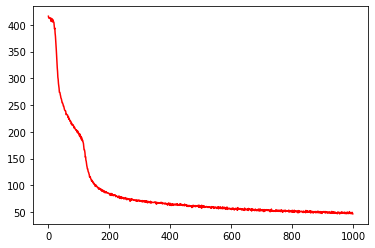

'Ok'

In [994]:
S = [10,5,1] # #neuronas x capa    
L = len(S) # #capas
B = 1 # mini-lotes incremental 1

lr = 0.01
T = 1000
model('model','tp1_ej1_training.csv','train')
model('model','tp1_ej1_training.csv','test')

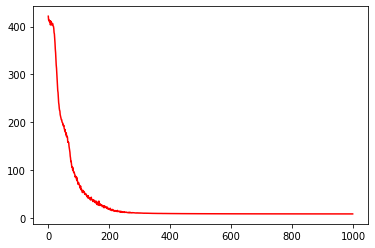

'Ok'

In [1001]:
S = [10,8,5,1] # #neuronas x capa    
L = len(S) # #capas
B = 1 # mini-lotes incremental 1

lr = 0.01
T = 1000
model('model2','tp1_ej1_training.csv','train')
model('model2','tp1_ej1_training.csv','test')

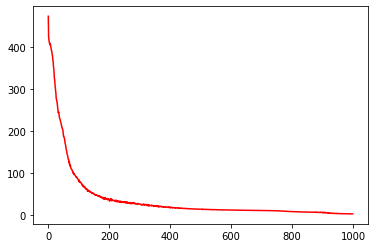

'Ok'

In [1004]:
S = [10,8,1] # #neuronas x capa    
L = len(S) # #capas
B = 1 # mini-lotes incremental 1

lr = 0.01
T = 1000
model('model3','tp1_ej1_training.csv','train')
model('model3','tp1_ej1_training.csv','test')

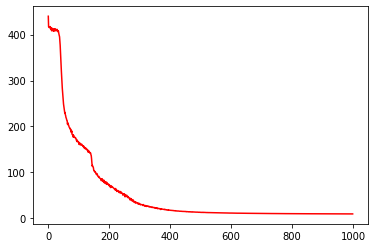

'Ok'

In [1015]:
S = [10,9,1] # #neuronas x capa    
L = len(S) # #capas
B = 1 # mini-lotes incremental 1

lr = 0.01
T = 1000
model('model3','tp1_ej1_training.csv','train')
model('model3','tp1_ej1_training.csv','test')